# About Qiskit Aer
Some sections in this notebook are adapted from [Qiskit tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/aer_provider.ipynb).

## Introduction

This notebook first demonstrates how to use simulators in Qiskit Aer to execute ideal (noiseless) quantum circuit. 

Then it shows how to incorporate device noise model into simulation and  compare the results from noisy simulation and real devices. 

In [1]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
from qiskit import Aer

### If any problem occurs when importing Aer, try to use BasicAer instead.
# from qiskit import BasicAer

from qiskit.tools.visualization import plot_histogram, plot_state_city

## Aer/BasicAer Simulator

`Aer` provides three kinds of high performance simulators written in C++: `QasmSimulator`, `StatevectorSimulator`, and `UnitarySimulator`. Similarly, `BasicAer` provides python version of the previous three simulators. 

Note that Python-based simulators are much slower. It's highly recommended to use Aer simulators if there's no any execution problems.

* `QasmSimulator`

    `QasmSimulator` backend allows <font color="red">both ideal and noisy multi-shot execution</font> of quantum circuits.
It executes a Qiskit `QuantumCircuit` and returns dictionary containing the final values of any classical registers in the circuit. 


* `StatevectorSimulator`

    `StatevectorSimulator` executes a single shot of a Qiskit `QuantumCircuit` and returns the final quantum statevector of the simulation.

    Note that elements in statevector is ordered as 00, 01, 10, 11 for two qubits. For more qubits it has similar ascending order.


* `UnitarySimulator`

    `UnitarySimulator` constructs the unitary matrix for a  `QuantumCircuit` by applying each gate matrix to an identity matrix. Note that the circuit may <font color="red">contain only gates</font>; measurements and resets are not allowed due to their non-unitarity.

In [3]:
from qiskit import Aer
backends = Aer.backends()
backends

### Or alternatively, three simulation backends can be imported directly
# from qiskit.providers.aer \
#     import QasmSimulator, StatevectorSimulator, UnitarySimulator

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

### QasmSimulator

Here we present a simple circuit preparing Bell state $
\frac{1}{\sqrt 2}(\left|00\right\rangle+\left|11\right\rangle)$
 and measure both qubits.

{'11': 488, '00': 536}


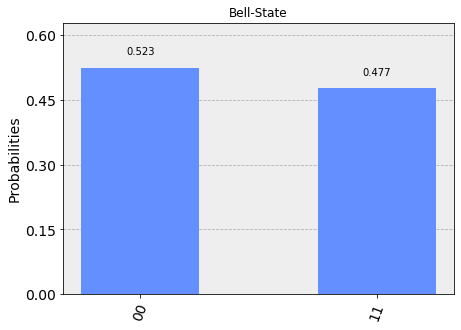

In [4]:
# Construct quantum circuit
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr)

# Select QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(qc, simulator).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts, title='Bell-State')

* `result` contains a lot information about the experiments (memory, counts, backend, taken time, etc)

### StatevectorSimulator
Here we produce the same Bell state as before, but use `StatevectorSimulator` to perform experiment.

####  Circuit and Final State
First, we construct the quantum circuit without measurements.

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


/Users/tsaicheng/anaconda3/lib/python3.7/site-packages/qiskit/visualization/state_visualization.py:770: MatplotlibDeprecationWarning: 
The mod function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.linalg.norm instead.
  for n in normals])


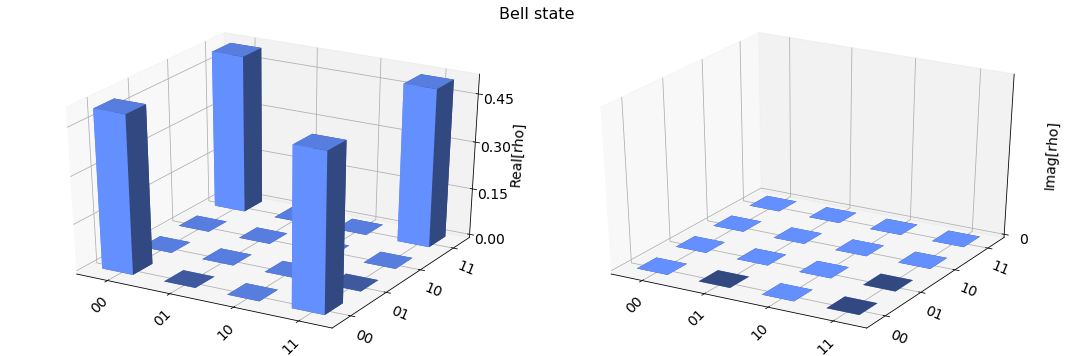

In [5]:
# Construct quantum circuit without measurements
num_qr = 2
qr = QuantumRegister(num_qr)
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(qc, simulator).result()
statevector = result.get_statevector(qc)
print(statevector)
plot_state_city(statevector, title='Bell state')


#### StatevectorSimulator and QasmSimulator
For a state 
\begin{equation}
    \left|\psi\right\rangle =
    a\left|00\right\rangle +
    b\left|01\right\rangle +
    c\left|10\right\rangle +
    d\left|11\right\rangle
\end{equation}

with $|a|^2+|b|^2+|c|^2+|d|^2 = 1$, probabilities for the measurement outcome being 00, 01, 10, 11 are $|a|^2$, $|b|^2$, $|c|^2$, and $|d|^2$, respectively.

Therefore, from the final statevector one may predict the result (qualitatively) of `QasmSimulator`. The following code generates `counts` data in `QasmSimulator` from final statevector.

{'00': 0.5000000000000001, '11': 0.4999999999999999}


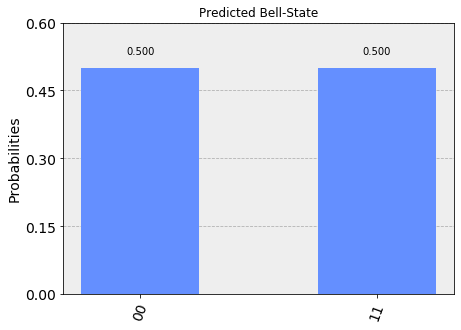

In [5]:
num_qr = 2
my_counts = {}

def get_my_counts(statevector, num, threshold = 1e-6):
    res = {}
    for i in range(2**num_qr):
        if abs(statevector[i])**2 < threshold: continue
        index = bin(i)[2:].zfill(num_qr)
        res[index] = abs(statevector[i])**2
    return res

my_counts = get_my_counts(statevector, num_qr)
print(my_counts)
plot_histogram(my_counts, title='Predicted Bell-State')

#### Measurement in StatevectorSimulator

An important feature in quantum physics is that a measurment of a superposition state makes it collapse into one of its basis state with probability related to coefficients.

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


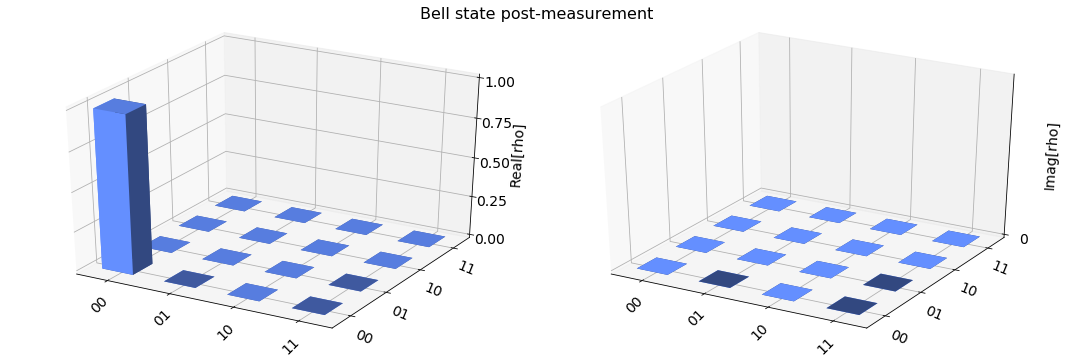

In [6]:
# Construct quantum circuit with measure
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr, cr)

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(qc, simulator).result()
statevector = result.get_statevector(qc)
print(statevector)
plot_state_city(statevector, title='Bell state post-measurement')

{'00': 1.0}


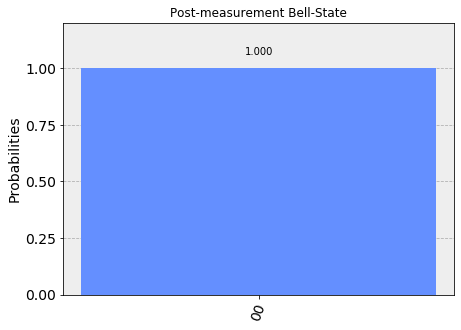

In [7]:
my_counts = get_my_counts(statevector, num_qr)
print(my_counts)
plot_histogram(my_counts, title='Post-measurement Bell-State')

### UnitarySimulator

Similar to previous sections, in this example we calculate the unitary matrix corresponding to the circuit which produces a bell state.

In [6]:
# Construct an empty quantum circuit
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.h(qr[0])
qc.cx(qr[0], qr[1])

# Select the UnitarySimulator from the Aer provider
simulator = Aer.get_backend('unitary_simulator')

# Execute and get counts
result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)
print("Circuit unitary:\n", unitary)

Circuit unitary:
 [[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j -0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]]


Some simple math shows the initial state (00) becomes the bell state obtained in `StatevectorSimulator` section after passing through the circuit (i.e. left-multiply with `unitary`).

In [9]:
initial_state = np.matrix([1,0,0,0]).T
final_state = np.matmul(unitary, initial_state)

final_state

matrix([[0.70710678+0.j],
        [0.        +0.j],
        [0.        +0.j],
        [0.70710678+0.j]])

#### Gate Identities

`UnitarySimulator` allows us to verify gate identites by directly comparing the unitary matrices of circuits. 

Here is a simple example: SWAP(0,1) = Cx(0,1)H(0)H(1)Cx(0,1)H(0)H(1)Cx(0,1)

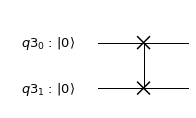

In [22]:
### Circuit 1

qr1 = QuantumRegister(2, 'q')
qc1 = QuantumCircuit(qr)

qc1.swap(0,1)

qc1.draw(output='mpl')

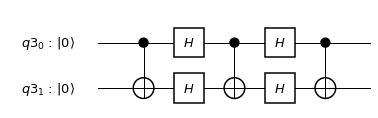

In [24]:
### Circuit 1

qr2 = QuantumRegister(2, 'q')
qc2 = QuantumCircuit(qr)

qc2.cx(0,1)
qc2.h([0,1])
qc2.cx(0,1)
qc2.h([0,1])
qc2.cx(0,1)

qc2.draw(output='mpl')

In [26]:
# Select the UnitarySimulator from the Aer provider
simulator = Aer.get_backend('unitary_simulator')

# Execute and get counts
result1 = execute(qc1, simulator).result()
result2 = execute(qc2, simulator).result()

unitary1 = result1.get_unitary(qc1)
unitary2 = result2.get_unitary(qc2)

print("Circuit 1 unitary:\n", unitary1, '\n')
print("Circuit 2 unitary:\n", unitary2)



Circuit 1 unitary:
 [[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]] 

Circuit 2 unitary:
 [[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


Another example: Cx(0,1)Y(1)Cx(0,1) = Z(0)Y(1)